# Active Subspace Analysis Notebook for Re-entry Vehicle

**DESCRIPTION**

This data set comes from a set of numerical simulations of an atmospheric re-entry vehicle performed by Pietro Congedo at INRIA-Bordeaux. The inputs are three parameters characterizing the free stream and four parameters characterizing the reacting chemistry of the heat shield. The outputs are the pressure and heat flux at the stagnation point of the re-entry vehicle. 

**INPUTS (7)**

Variable | Lower bound | Upper bound | Density
--- | --- | --- | ---
Free stream pressure | 16.3 | 24.3 | Uniform
Free stream mach number | 13.7 | 17.3 | Uniform
Catalytic recombination coefficient | 0.001 | 0.002 | Uniform

The reaction rates are normalized to be centered at their respective means.

Variable | Mean | Std dev | Density
--- | --- | --- | ---
Log of reaction rate (NO+O -> N+O+O) | 0 | 0.12 | Gaussian
Log of reaction rate (NO+N -> N+O+N) | 0 | 0.10 | Gaussian
Log of reaction rate (O2+N2 -> 2O+N2) | 0 | 0.10 | Gaussian
Log of reaction rate (O2+O -> 2O+O) | 0 | 0.10 | Gaussian

**OUTPUTS (2)**

Variable | Description
--- | --- 
wall_press | Pressure at stagnation point
heat_flux | Heat flux at stagnation point

**REFERENCES**

+ Tryoen, Congedo, Abgrall, Villedieu, and Magin. [Bayesian-Based Method with Metamodels for Rebuilding Freestream Conditions in Atmospheric Entry Flows](http://arc.aiaa.org/doi/abs/10.2514/1.J052831)
+ Constantine, Dow, and Wang. [Active Subspace Methods in Theory and Practice: Applications to Kriging Surfaces](http://epubs.siam.org/doi/abs/10.1137/130916138)

**CONTACT**

Questions or comments? Contact [Paul Constantine](mailto:pconstan@mines.edu)


In [1]:
import numpy as np
import pandas as pn
import active_subspaces as ac
%matplotlib inline

Import the data set, distinguish inputs (X) and outputs (F), and set the labels.

In [2]:
df = pn.DataFrame.from_csv('reentry.txt')
data = df.as_matrix()
X = data[:,0:7]
F = data[:,7:9]
M,m = X.shape
labels = df.keys()
in_labels = labels[:7]
out_labels = labels[7:9]

Normalize the uniformly distributed inputs to the interval [-1,1], and normalize the Gaussian distributed inputs to standard Gaussians.

In [3]:
xl = np.array([16.3,13.7,0.001])
xu = np.array([24.3,17.3,0.002])
XX = X.copy()
XX[:,:3] = ac.utils.misc.BoundedNormalizer(xl,xu).normalize(X[:,:3])
xmean = np.zeros((1,4))
xstd = np.diagflat(np.array([0.12,0.12,0.1,0.1]))
XX[:,3:] = ac.utils.misc.UnboundedNormalizer(xmean,xstd).normalize(X[:,3:])

Choose the output of interest.

In [4]:
out_index = 1 # either 0 or 1
f = F[:,out_index]
out_label = out_labels[out_index]

Run the check with the linear model.

In [5]:
ss = ac.subspaces.Subspaces()
ss.compute(f=f[:,np.newaxis],X=XX,sstype=5,nboot=200)

Display the one-dimensional sufficient summary plot.

/home/ryhoward/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


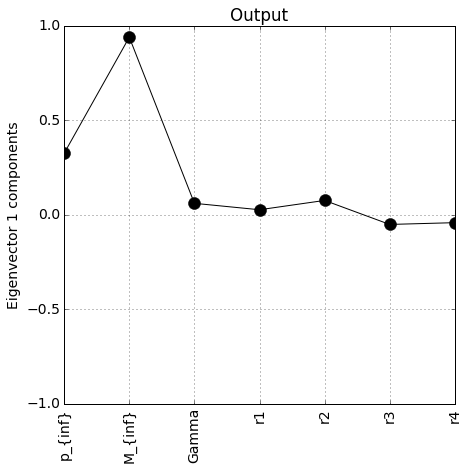

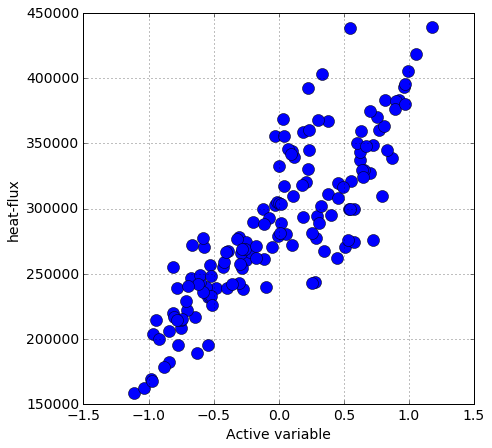

In [6]:
ss.partition(1)
y = np.dot(XX,ss.W1) # active variables
ac.utils.plotters.eigenvectors(ss.W1,in_labels=in_labels)
ac.utils.plotters.sufficient_summary(y,f,out_label=out_label)

Get the active subspace using approximate gradients from local linear models. 

In [7]:
G = ac.local_linear_gradients(XX,f)
ass = ac.subspaces.Subspaces()
ass.compute(df=G,nboot=2000)

Plot active subspace components.

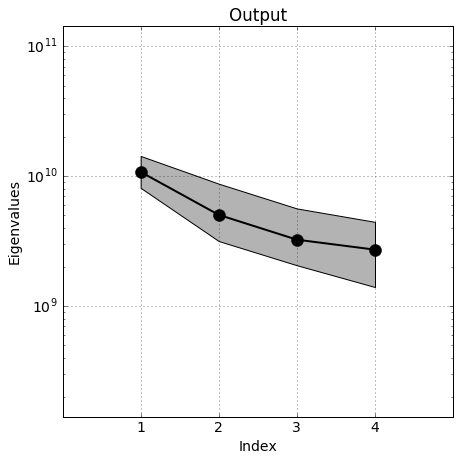

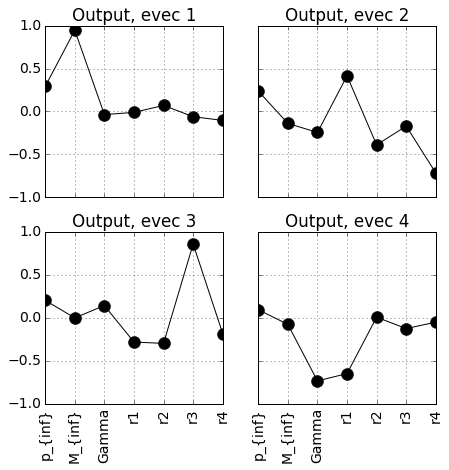

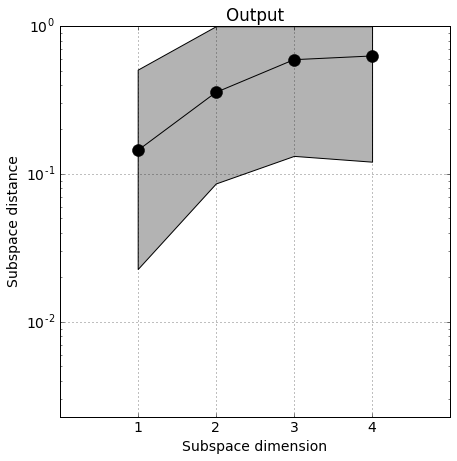

In [8]:
k=4
ac.utils.plotters.eigenvalues(ass.eigenvalues[:k],ass.e_br[:k,:])
ac.utils.plotters.eigenvectors(np.hstack((ass.W1,ass.W2)),in_labels=in_labels)
ac.utils.plotters.subspace_errors(ass.sub_br[:k,:])

Make sufficient summary plots. 

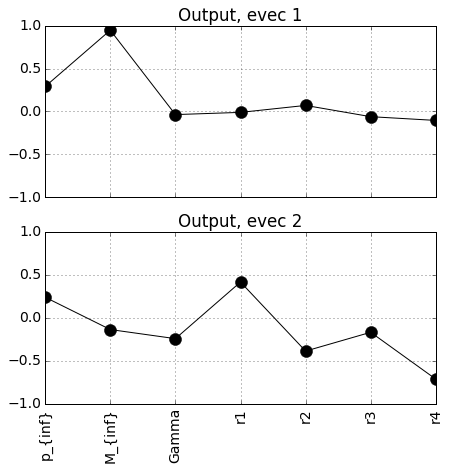

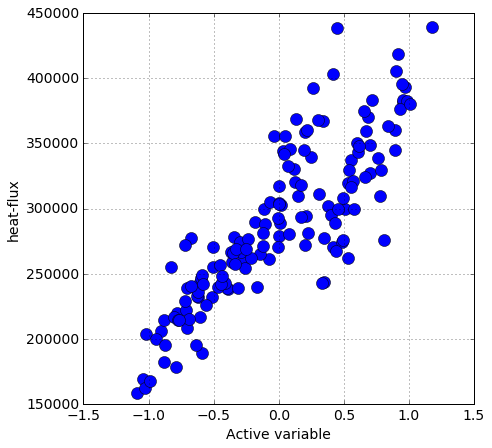

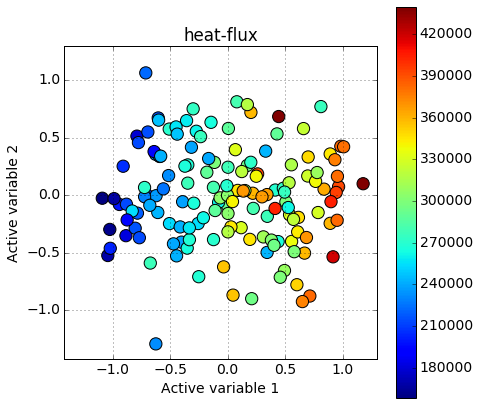

In [9]:
ass.partition(2)
y = np.dot(XX,ass.W1) # active variables
ac.utils.plotters.eigenvectors(ass.W1,in_labels=in_labels)
ac.utils.plotters.sufficient_summary(y,f,out_label=out_label)